In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import numpy as np

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

In [6]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

print (df.shape)
print (df.columns)


df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

(3066766, 19)
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


## Q2. Computing duration

In [7]:
df.duration.std()

42.594351241920904

In [8]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

# df.duration.std()

## Q3. Dropping outliers

In [9]:
print (len(df) / 3066766)

0.9812202822125979


## Q4. One-hot encoding

In [10]:
train_dicts = df[categorical ].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print (X_train.shape)

(3009173, 515)


## Q5. Training a model

In [11]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.6492610279057605

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


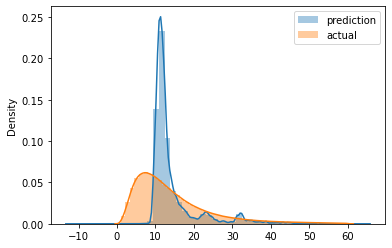

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

## Q6. Evaluating the model

In [14]:
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')
print (df_val.shape)
df_val.columns

(2855951, 20)


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'duration'],
      dtype='object')

In [15]:
val_dicts = df_val[categorical ].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = df_val[target].values
print (X_val.shape, y_val.shape)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

(2855951, 515) (2855951,)


7.81183265470218

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
# lr_l = Lasso(0.01)
# lr_l.fit(X_train, y_train)

# y_pred = lr_l.predict(X_val)

# mean_squared_error(y_val, y_pred, squared=False)